# Experiment 1

How well do TPMS scores predict bids?

The deliverable will be a plot showing the performance of the TPMS scores on the "recall@M" evaluation metric.

Plan:
- load eval data for UAI 18 conference
- load a model (which could be pre-trained, if the model requires training)
- evaluate the model and produce graphs

In [1]:
import os, sys

import json, csv
import itertools

import openreview
import numpy

from collections import defaultdict
from expertise.models import tfidf, randomize, model_utils

## Data


Load up data from OpenReview and organize it into various indices

In [2]:
client = openreview.Client()

papers = client.get_notes(invitation='auai.org/UAI/2018/-/Blind_Submission')
paper_by_number = {n.number: n for n in papers}

reviewers = client.get_group('auai.org/UAI/2018/Program_Committee')

all_tags = list(openreview.tools.iterget_tags(client, invitation='auai.org/UAI/2018/-/Add_Bid'))

binned_tags = {
    'i want to review': [],
    'i can review': [],
    'i can probably review but am not an expert': [],
    'i cannot review': [],
    'no bid': []
}

users_w_bids = set()
for tag in all_tags:
    binned_tags[tag.tag.lower()].append(tag)
    users_w_bids.update(tag.signatures)

for b in binned_tags:
    print(b, len(binned_tags[b]))

bids_by_forum = defaultdict(list)
for tag in all_tags:
    bids_by_forum[tag.forum].append(tag)

i can review 2256
i can probably review but am not an expert 2633
i want to review 1486
i cannot review 9024
no bid 754


## Models

Models should all have a function with the following contract:

```
def score(archive_text, paper_text):
    '''
    Returns a score from 0.0 to 1.0, representing the degree of fit between the paper and the reviewer
    '''
```

TF-IDF model

Run the tf-idf model using `openreview-expertise/samples/uai-process-tfidf.py`, then read from the resulting file

In [3]:
tfidf_score_matrix = {}
with open('old-scores') as f:
    lines = [line.replace('\n','') for line in f.readlines()]

for line in lines:
    note_id, reviewer_id, score = eval(line)
    if note_id not in tfidf_score_matrix:
        tfidf_score_matrix[note_id] = {}
    if reviewer_id not in tfidf_score_matrix[note_id]:
        tfidf_score_matrix[note_id][reviewer_id] = score
    else:
        raise('pair already seen ', note_id, reviewer_id, score)
        
tfidf_ranklists = model_utils.matrix_to_ranklists(tfidf_score_matrix)

TPMS "model"

(it's actually just the output of a model. We don't have access to TPMS directly)

In [4]:
# score_matrix['abcXYZ']['~Michael_Spector'] = the TPMS score of Michael Spector with paper 1
tpms_score_matrix = defaultdict(dict) 
users_w_scores = set()

with open('/Users/michaelspector/projects/openreview/openreview-expertise/data/uai18/uai18-tpms-scores.csv') as f:
    reader = csv.reader(f)
    try:
        for row in reader:
            papernum, user_id, score, email = row
            paper = paper_by_number.get(int(papernum))
            if paper:
                users_w_scores.update([user_id])
                tpms_score_matrix[paper.id][user_id] = score
            
    except UnicodeDecodeError as e:
        print(e)
        raise(e)

# convert the score matrix to a list of "ranklists", for now.
# this is mostly being done so that I don't have to rewrite a lot of code. In the future this may not be necessary.
tpms_ranklists = model_utils.matrix_to_ranklists(tpms_score_matrix)

Random model

In [5]:
# instantiate the model
randomize_model = randomize.Model()

randomize_score_matrix = defaultdict(dict)
for paper in papers:
    for reviewer_id in reviewers.members:
        randomize_score_matrix[paper.id][reviewer_id] = randomize_model.score()

# convert the score matrix to a list of "ranklists", for now.
# this is mostly being done so that I don't have to rewrite a lot of code. In the future this may not be necessary.
random_ranklists = model_utils.matrix_to_ranklists(randomize_score_matrix)

## Evaluation & Graphing

In [6]:
from expertise.evaluators import recall_at_m
from expertise import graphing
import numpy as np
import matplotlib, matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [7]:
evaluator = recall_at_m.Evaluator(bids_by_forum=bids_by_forum)

In [8]:
def get_avg_scores(ranklists, evaluator):
    all_scores = []
    for forum, scores in evaluator.evaluate(ranklists):
        all_scores.append(scores)
    if all_scores:
        avg_scores = np.mean(all_scores, axis=0)
    else:
        avg_scores = []
        
    return avg_scores

In [9]:
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)

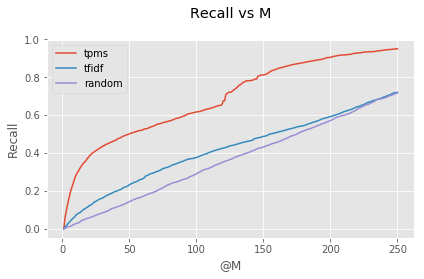

In [10]:
fig, ax = plt.subplots()

ax = graphing.recall_at_m(tpms_avg_scores, ax, 'tpms')
ax = graphing.recall_at_m(tfidf_avg_scores, ax, 'tfidf')
ax = graphing.recall_at_m(random_avg_scores, ax, 'random')

plt.tight_layout()

filename = 'tpms-tfidf-random'
fig.savefig("./{0}.png".format(filename), dpi=200)